## Description
A term deposit an investment where money is deposited for a fixed period at a financial institution. The deposited money earns a set interest rate however, the funds cannot be accessed until the end of the term. The objective of analyzing the bank marketing is to determine the primary characteristics driving term deposit purchases and predicting when a customer will subscribe to a term deposit.

The data comes from the [Bank Marketing dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing) from the UC Irvine Machine Learning Repository and consists of data from 17 marketing campaigns from a Portugese bank that occurred between May 2008 and November 2010.


## Imports and Data File Loading

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# pip installations
!pip install category_encoders

In [47]:
import pandas as pd
import seaborn as sns
import numpy as np

from category_encoders import JamesSteinEncoder
from collections import namedtuple
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, recall_score, precision_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

In [48]:
# access can be confirmed by using the magic command for ls:
!ls "/content/drive/MyDrive/UCB/Assignments/Assignment3/data"
datapath = "/content/drive/MyDrive/UCB/Assignments/Assignment3/data"

bank-additional.csv  bank-additional-full.csv  bank-additional-names.txt


In [49]:
datafilepath = datapath + "/bank-additional.csv"

df_original = pd.read_csv(datafilepath, sep = ';')

## Functions

### DataFrame Processing Functions

In [50]:
def get_nan_stats(dataframe):
  nan_stats_df = pd.DataFrame(dataframe.isnull().sum(), columns=['count'])
  nan_stats_df['percentage'] = round((nan_stats_df['count'] * 100)/ dataframe.shape[0], 2)

  return nan_stats_df

In [51]:
def get_string_of_column_values(dataframe, column_name):
  series = dataframe[column_name].value_counts()

  column_values = ''
  for index, value in zip(series.index, series.values):
    column_values += str(index) + ", "

  return column_values[:-2] if len(column_values) >= 2 else column_values


In [52]:
def print_column_value_counts(dataframe, threshold = 16):
  for column_index in range(len(dataframe.columns)):
    column_name = dataframe.columns[column_index]
    value_counts = len(dataframe[column_name].value_counts())

    # print the column values if the number is limited
    column_values = ""
    if value_counts < threshold:
      column_values = get_string_of_column_values(dataframe, column_name)

    print(str(column_index) + ": " + column_name + ": " + str(value_counts) + " values: " + column_values)

In [53]:
'''
Performs James-Stein encoding and standard scaling on original bank marketing dataset in order to perform exploratory data analysis.
Returns a DataFrame with the encoded and scaled data.
'''
def get_jamesstein_and_scaled_X_and_y(unprocessed_dataframe):
  df = unprocessed_dataframe.copy()
  X_eda = df.drop(columns=['y'])

  # encode target values 'yes', 'no' to 1 and 0
  y_eda = df['y'].map({'yes': 1, 'no': 0})

  # list of all category columns in the original bank marketing dataset
  category_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

  # perform James-Stein target encoding on categorical variables
  js_encoder = JamesSteinEncoder(cols=category_columns)
  X_eda_encoded = js_encoder.fit_transform(X_eda, y_eda)

  scaler = StandardScaler()
  X_eda_encoded_and_scaled = scaler.fit_transform(X_eda_encoded)

  X = pd.DataFrame(X_eda_encoded_and_scaled, columns=X_eda.columns)
  y = y_eda

  return X, y

In [54]:
'''
Remove unused columns from original bank marketing datase, perform James-Stein encoding and standard scaling.
Returns a DataFrame with the encoded and scaled data.
'''
def process_dataset(unprocessed_dataframe):
  X, y = get_jamesstein_and_scaled_X_and_y(unprocessed_dataframe)

  # drop unused columns default, duration and pdays
  # default: unbalanced and unimputable. no/unknown/yes: 3315,803,1
  # duration: recommended by authors to be dropped since it is highly correlated with the target
  # pdays: highly unbalanced, 3959/4119 have the value "999", which means client was not previously contacted
  X.drop(columns=['default', 'duration', 'pdays'], inplace=True)

  # drop columns highly correlated with nr.employed
  X.drop(columns=['cons.price.idx', 'emp.var.rate'], inplace=True)

  return X, y

In [55]:
def get_selected_features_and_y(unprocessed_dataframe, selected_features):
  X, y = get_jamesstein_and_scaled_X_and_y(unprocessed_dataframe)

  X_selected_features = X[selected_features.tolist()].copy()


  return X_selected_features, y

### GridSearch Functions

In [56]:
''' function to simplify grid search approach for all estimators'''
def perform_grid_search(pipeline, param_grid, scoring='recall'):
  # print('performing HalvingGridSearchCV')
  # return HalvingGridSearchCV(dt_pipeline, param_grid=param_grid, cv=2, scoring='recall')

  print('performing GridSearchCV')
  return GridSearchCV(pipeline, param_grid=param_grid, cv=2, scoring='recall')

### Graphing and Results Functions

In [57]:
def print_scores(description, y_actual, y_pred):
  print(f"confusion matrix ({description}):")
  print(confusion_matrix(y_actual, y_pred, labels=[True, False]))
  print()

  print(f"classification report ({description}):")
  print(classification_report(y_actual, y_pred, labels=[True, False]))
  print()

def print_model_info(model):
  print("model.get_params():")
  print(model.get_params())
  print()

def print_model_info_from_gridsearch(gridsearch):
  print("best_params_:")
  print(gridsearch.best_params_)

  best_estimator = gridsearch.best_estimator_
  print("best_estimator_:")
  print(best_estimator.get_params())
  print()

In [58]:
def print_metrics(y_test, y_pred, y_prob, thresholds):
  labels = [True, False]

  for threshold in thresholds:
    threshold_metrics = ''
    cm = r = p = f1 = ''
    prob_predictions = np.where(y_prob > threshold, 1, 0)

    r = round(recall_score(y_test, prob_predictions, labels=labels), 3)
    p = round(precision_score(y_test, prob_predictions, labels=labels), 3)
    f1 = round(f1_score(y_test, prob_predictions, labels=labels), 3)

    threshold_metrics = f'threshold = {threshold}: recall={r}, precision={p}, f1={f1}'

    cm = confusion_matrix(y_test, prob_predictions, labels=labels)

    print(threshold_metrics)
    print(cm)
    print()

In [59]:
def display_precision_recall_curve(precision_series, recall_series, label):
  plt.figure(figsize=(8,6))
  plt.plot(recall_series, precision_series, marker='.', label=f'{label}')

  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend()
  plt.grid()
  plt.show()

### Pipeline Functions

In [60]:
# declarations
dataset_category_columns = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [61]:
''' lasso pipeline for identifying features'''
def create_lasso_pipeline(alpha):

  dataset_category_columns = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
  lasso_pipeline = Pipeline([
     ('js_encoder', JamesSteinEncoder(cols=dataset_category_columns)),
     ('scaler', StandardScaler()),
     ('lasso', Lasso(alpha = alpha))
  ])

  return lasso_pipeline

In [62]:
''' Creates pipeline for machine learning model scoring'''
def create_model_pipeline(category_columns, model):

  model_pipeline = Pipeline([
     ('js_encoder', JamesSteinEncoder(cols=category_columns)),
     ('scaler', StandardScaler()),
     ('model', model)
  ])

  return model_pipeline

## Exploratory Data Analysis

### Initial Investigations

In [63]:
df_original.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no


In [64]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [65]:
df_original.describe().style.format("{:.2f}")
# 10 of 21 columns are numeric

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.00,4119.00,4119.00,4119.00,4119.00,4119.00,4119.00,4119.00,4119.00,4119.00
mean,40.11,256.79,2.54,960.42,0.19,0.08,93.58,-40.50,3.62,5166.48
std,10.31,254.70,2.57,191.92,0.54,1.56,0.58,4.59,1.73,73.67
min,18.00,0.00,1.00,0.00,0.00,-3.40,92.20,-50.80,0.64,4963.60
25%,32.00,103.00,1.00,999.00,0.00,-1.80,93.08,-42.70,1.33,5099.10
50%,38.00,181.00,2.00,999.00,0.00,1.10,93.75,-41.80,4.86,5191.00
75%,47.00,317.00,3.00,999.00,0.00,1.40,93.99,-36.40,4.96,5228.10
max,88.00,3643.00,35.00,999.00,6.00,1.40,94.77,-26.90,5.04,5228.10


In [66]:
nan_stats_df = get_nan_stats(df_original)
nan_stats_df
# no NaNs appear in the data

,count,percentage
age,0,0.0
job,0,0.0
marital,0,0.0
education,0,0.0
default,0,0.0
housing,0,0.0
loan,0,0.0
contact,0,0.0
month,0,0.0
day_of_week,0,0.0


In [67]:
print_column_value_counts(df_original)

0: age: 67 values: 
1: job: 12 values: admin., blue-collar, technician, services, management, retired, self-employed, entrepreneur, unemployed, housemaid, student, unknown
2: marital: 4 values: married, single, divorced, unknown
3: education: 8 values: university.degree, high.school, basic.9y, professional.course, basic.4y, basic.6y, unknown, illiterate
4: default: 3 values: no, unknown, yes
5: housing: 3 values: yes, no, unknown
6: loan: 3 values: no, yes, unknown
7: contact: 2 values: cellular, telephone
8: month: 10 values: may, jul, aug, jun, nov, apr, oct, sep, mar, dec
9: day_of_week: 5 values: thu, mon, tue, wed, fri
10: duration: 828 values: 
11: campaign: 25 values: 
12: pdays: 21 values: 
13: previous: 7 values: 0, 1, 2, 3, 4, 5, 6
14: poutcome: 3 values: nonexistent, failure, success
15: emp.var.rate: 10 values: 1.4, -1.8, 1.1, -0.1, -2.9, -3.4, -1.7, -1.1, -3.0, -0.2
16: cons.price.idx: 26 values: 
17: cons.conf.idx: 26 values: 
18: euribor3m: 234 values: 
19: nr.employed: 

### Initial Feature Correlations

<Axes: >

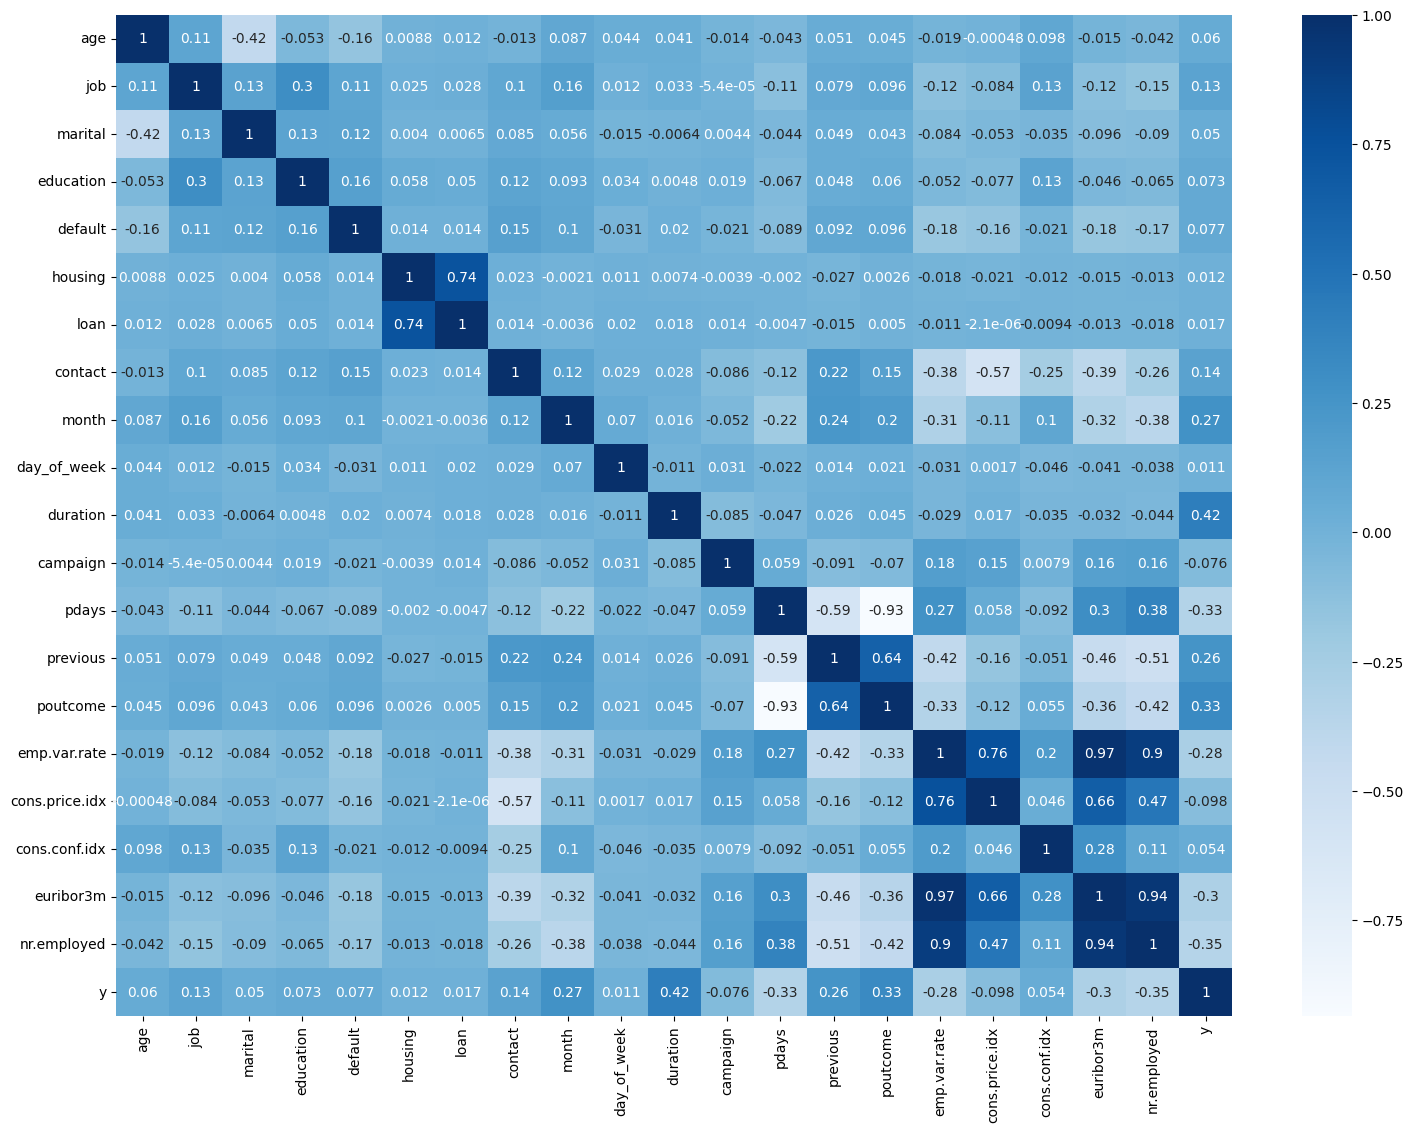

In [68]:
# get initial feature correlations
X, y = get_jamesstein_and_scaled_X_and_y(df_original)
combined_df = pd.concat([X, y], axis=1)
corr = combined_df.corr()

fig, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(corr, annot=True, ax=ax, cmap='Blues')

### Feature Identification with LASSO

In [69]:
# train test split
X, y = process_dataset(df_original) # remove irrelevant features
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,
                                                   stratify = y)

lasso_cv = LassoCV(cv=5).fit(X_train, y_train)
print("Optimal alpha:", lasso_cv.alpha_)

Optimal alpha: 0.004182164605069941


In [70]:
alpha = lasso_cv.alpha_

lasso_pipeline = create_lasso_pipeline(alpha)
lasso_pipeline.fit(X_train, y_train)

coefs = lasso_pipeline.named_steps['lasso'].coef_
feature_names = X_train.columns.values

dict = {
    'feature_names': feature_names,
    'coef': coefs
    }

features_and_coefs_df = pd.DataFrame(dict)
lasso_selected_features_df = features_and_coefs_df.loc[features_and_coefs_df['coef'] != 0]
lasso_selected_features_df = lasso_selected_features_df.sort_values(by='coef', ascending=False)
lasso_selected_features_df

,feature_names,coef
11,poutcome,0.060599
7,month,0.036028
1,job,0.015341
12,cons.conf.idx,0.014692
6,contact,0.007490
2,marital,0.006421
0,age,0.003058
4,housing,0.001774
9,campaign,-0.002863
14,nr.employed,-0.060923


## Machine Learning Models

In [71]:
# get the lasso identified features
selected_features = lasso_selected_features_df['feature_names'].values
print('lasso selected features: ' + str(selected_features))

# category features to convert by james-stein encoder
category_columns = ['poutcome', 'month', 'job', 'contact', 'marital', 'housing']
print('category features: ' + str(category_columns))

lasso selected features: ['poutcome' 'month' 'job' 'cons.conf.idx' 'contact' 'marital' 'age'
 'housing' 'campaign' 'nr.employed']
category features: ['poutcome', 'month', 'job', 'contact', 'marital', 'housing']


### Baseline

In [89]:
# establish a baseline using DummyClassifier
X, y = get_selected_features_and_y(df_original, selected_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,
                                                   stratify = y)

bl_pipeline = create_model_pipeline(
    category_columns = category_columns,
    model = DummyClassifier())

param_grid = {
    'model__strategy': ['stratified'],
    'model__random_state': [42],
}

bl_grid = perform_grid_search(bl_pipeline, param_grid=param_grid)
bl_grid.fit(X_train, y_train)

best_estimator_bl = bl_grid.best_estimator_
y_pred = best_estimator_bl.predict(X_test)

print_model_info(best_estimator_bl)
print_scores("decision tree test", y_test.values, y_pred)

y_pred_probs = best_estimator_bl.predict_proba(X_test)[:, 1]
bl_precision, bl_recall, bl_thresholds = precision_recall_curve(y_test, y_pred_probs)



performing GridSearchCV
model.get_params():
{'memory': None, 'steps': [('js_encoder', JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing'])), ('scaler', StandardScaler()), ('model', DummyClassifier(random_state=42, strategy='stratified'))], 'transform_input': None, 'verbose': False, 'js_encoder': JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing']), 'scaler': StandardScaler(), 'model': DummyClassifier(random_state=42, strategy='stratified'), 'js_encoder__cols': ['poutcome', 'month', 'job', 'contact', 'marital', 'housing'], 'js_encoder__drop_invariant': False, 'js_encoder__handle_missing': 'value', 'js_encoder__handle_unknown': 'value', 'js_encoder__model': 'independent', 'js_encoder__random_state': None, 'js_encoder__randomized': False, 'js_encoder__return_df': True, 'js_encoder__sigma': 0.05, 'js_encoder__verbose': 0, 'scaler__copy': True, 'scaler__with_mean': True, 'scaler

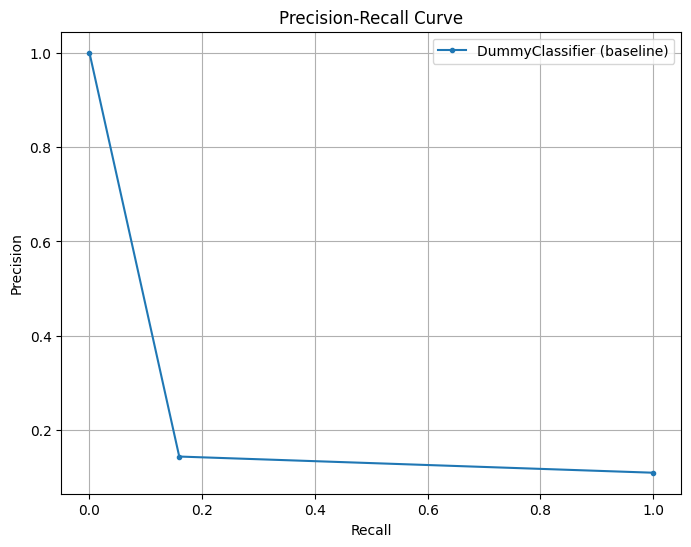

In [90]:
# precision-recall curve for decision tree
display_precision_recall_curve(bl_precision, bl_recall, 'DummyClassifier (baseline)')

In [91]:
thresholds = [0.4, 0.5, 0.6]
print_metrics(y_test, y_pred, y_pred_probs, thresholds = thresholds)

threshold = 0.4: recall=0.159, precision=0.144, f1=0.151
[[ 18  95]
 [107 810]]

threshold = 0.5: recall=0.159, precision=0.144, f1=0.151
[[ 18  95]
 [107 810]]

threshold = 0.6: recall=0.159, precision=0.144, f1=0.151
[[ 18  95]
 [107 810]]



### Decision Tree

In [75]:
# decision tree grid search
X, y = get_selected_features_and_y(df_original, selected_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,
                                                   stratify = y)

dt_pipeline = create_model_pipeline(
    category_columns = category_columns,
    model = DecisionTreeClassifier())

param_grid = {
    'model__class_weight': ['balanced'],
    'model__max_depth': [2, 3, 4, 5, 6, 7],
    'model__min_samples_leaf': [1, 2, 3],
    'model__min_samples_split': [2, 3, 4],
    'model__criterion': ['gini', 'entropy'],
    'model__random_state': [42],
}

dt_grid = perform_grid_search(dt_pipeline, param_grid=param_grid)
dt_grid.fit(X_train, y_train)

best_estimator_dt = dt_grid.best_estimator_
y_pred = best_estimator_dt.predict(X_test)

print_model_info(best_estimator_dt)
print_scores("decision tree test", y_test.values, y_pred)

y_pred_probs = best_estimator_dt.predict_proba(X_test)[:, 1]
dt_precision, dt_recall, dt_thresholds = precision_recall_curve(y_test, y_pred_probs)

performing GridSearchCV
model.get_params():
{'memory': None, 'steps': [('js_encoder', JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing'])), ('scaler', StandardScaler()), ('model', DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42))], 'transform_input': None, 'verbose': False, 'js_encoder': JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing']), 'scaler': StandardScaler(), 'model': DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42), 'js_encoder__cols': ['poutcome', 'month', 'job', 'contact', 'marital', 'housing'], 'js_encoder__drop_invariant': False, 'js_encoder__handle_missing': 'value', 'js_encoder__handle_unknown': 'value', 'js_encoder__model': 'independent', 'js_encoder__random_state': None, 'js_encoder__randomized': False, 'js_encoder__return_df': True, 'js_encoder__sigma': 0.05, 'js_encoder__verbose': 0, 'scaler__cop

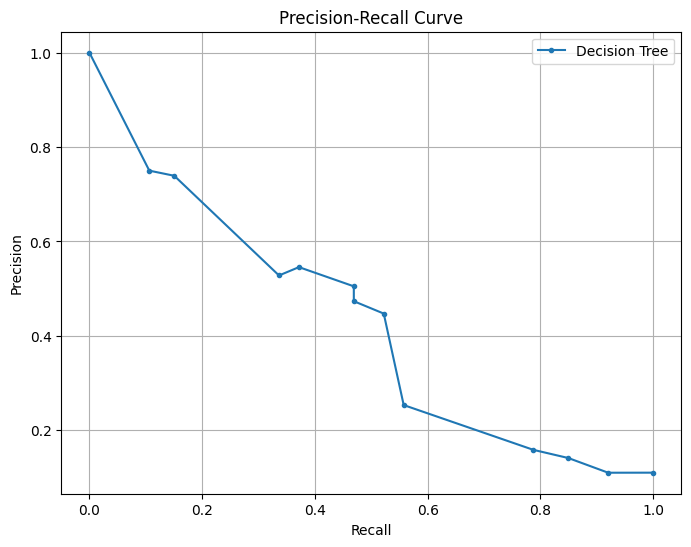

In [76]:
# precision-recall curve for decision tree
display_precision_recall_curve(dt_precision, dt_recall, 'Decision Tree')

In [77]:
thresholds = [0.4, 0.5, 0.6]
print_metrics(y_test, y_pred, y_pred_probs, thresholds = thresholds)

threshold = 0.4: recall=0.558, precision=0.253, f1=0.348
[[ 63  50]
 [186 731]]

threshold = 0.5: recall=0.522, precision=0.447, f1=0.482
[[ 59  54]
 [ 73 844]]

threshold = 0.6: recall=0.522, precision=0.447, f1=0.482
[[ 59  54]
 [ 73 844]]



#### Observations
The decision tree precison-recall curve is very deflated. Adjusting the decision threshold down towards 0.4 slightly affects the recall but negatively affects precision. Keeping the decision threshold at 0.5 maintains a trade-off between recall and precision.

### Logistic Regression

In [78]:
# logistic regression grid search
X, y = get_selected_features_and_y(df_original, selected_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,
                                                   stratify = y)

lr_pipeline = create_model_pipeline(
    category_columns = category_columns,
    model = LogisticRegression())

param_grid = {
    'model__penalty': ['l1', 'l2'],
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'model__solver': ['liblinear'],
    'model__max_iter': [100, 1000],
    'model__fit_intercept': [True, False],
    'model__class_weight': ['balanced'],
    'model__random_state': [42],
}

lr_grid = perform_grid_search(lr_pipeline, param_grid=param_grid)
lr_grid.fit(X_train, y_train)

best_estimator_lr = lr_grid.best_estimator_
y_pred = best_estimator_lr.predict(X_test)

print_model_info(best_estimator_lr)
print_scores("logistic regression test", y_test.values, y_pred)

y_pred_probs = best_estimator_lr.predict_proba(X_test)[:, 1]
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_test, y_pred_probs)

performing GridSearchCV
model.get_params():
{'memory': None, 'steps': [('js_encoder', JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing'])), ('scaler', StandardScaler()), ('model', LogisticRegression(C=0.01, class_weight='balanced', fit_intercept=False,
                   random_state=42, solver='liblinear'))], 'transform_input': None, 'verbose': False, 'js_encoder': JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing']), 'scaler': StandardScaler(), 'model': LogisticRegression(C=0.01, class_weight='balanced', fit_intercept=False,
                   random_state=42, solver='liblinear'), 'js_encoder__cols': ['poutcome', 'month', 'job', 'contact', 'marital', 'housing'], 'js_encoder__drop_invariant': False, 'js_encoder__handle_missing': 'value', 'js_encoder__handle_unknown': 'value', 'js_encoder__model': 'independent', 'js_encoder__random_state': None, 'js_encoder__randomized': F

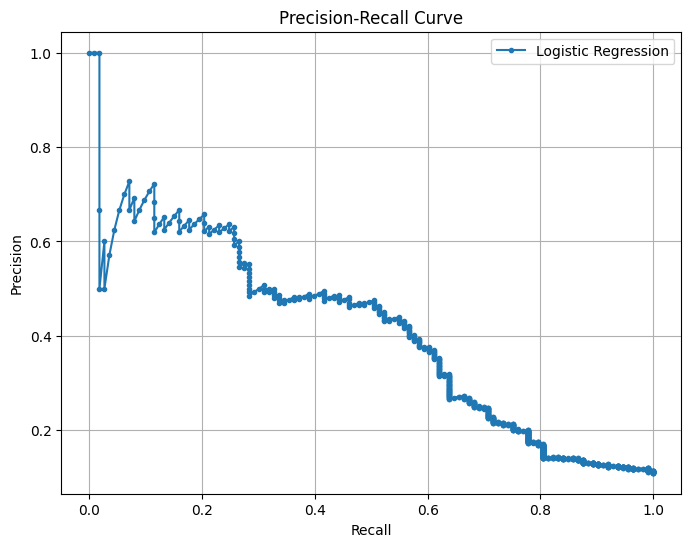

In [79]:
# precision-recall curve for logistic regression
display_precision_recall_curve(lr_precision, lr_recall, 'Logistic Regression')

In [80]:
thresholds = [0.4, 0.5, 0.6]
print_metrics(y_test, y_pred, y_pred_probs, thresholds = thresholds)

threshold = 0.4: recall=0.805, precision=0.141, f1=0.24
[[ 91  22]
 [553 364]]

threshold = 0.5: recall=0.708, precision=0.232, f1=0.349
[[ 80  33]
 [265 652]]

threshold = 0.6: recall=0.611, precision=0.369, f1=0.46
[[ 69  44]
 [118 799]]



#### Observations
Similar to the decision tree, the logistic regression precison-recall curve is also very deflated. Adjusting the decision threshold down towards 0.4 positively affects the recall, however as a consequence the false positives nearly double. Keeping the decision threshold at 0.5 maintains a trade-off between recall and precision.

`lbfgs` was excluded as an argument to `solver` because it caused   `FitFailedWarning` messages as `lbfgs` only supports l2 regularization. Additionally it didn't create any logistic regression instances that performed better than `liblinear`.

### K-Nearest Neighbors

In [81]:
# k-nearest neighbors grid search
X, y = get_selected_features_and_y(df_original, selected_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,
                                                   stratify = y)

knn_pipeline = create_model_pipeline(
    category_columns = category_columns,
    model = KNeighborsClassifier())

param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

knn_grid = perform_grid_search(knn_pipeline, param_grid=param_grid)
knn_grid.fit(X_train, y_train)

best_estimator_knn = knn_grid.best_estimator_
y_pred = best_estimator_knn.predict(X_test)

print_model_info(best_estimator_knn)
print_scores("k-nearest neighbors test", y_test.values, y_pred)

y_pred_probs = best_estimator_knn.predict_proba(X_test)[:, 1]
knn_precision, knn_recall, knn_thresholds = precision_recall_curve(y_test, y_pred_probs)

performing GridSearchCV
model.get_params():
{'memory': None, 'steps': [('js_encoder', JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing'])), ('scaler', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=3, weights='distance'))], 'transform_input': None, 'verbose': False, 'js_encoder': JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing']), 'scaler': StandardScaler(), 'model': KNeighborsClassifier(n_neighbors=3, weights='distance'), 'js_encoder__cols': ['poutcome', 'month', 'job', 'contact', 'marital', 'housing'], 'js_encoder__drop_invariant': False, 'js_encoder__handle_missing': 'value', 'js_encoder__handle_unknown': 'value', 'js_encoder__model': 'independent', 'js_encoder__random_state': None, 'js_encoder__randomized': False, 'js_encoder__return_df': True, 'js_encoder__sigma': 0.05, 'js_encoder__verbose': 0, 'scaler__copy': True, 'scaler__with_mean': True, 'scaler

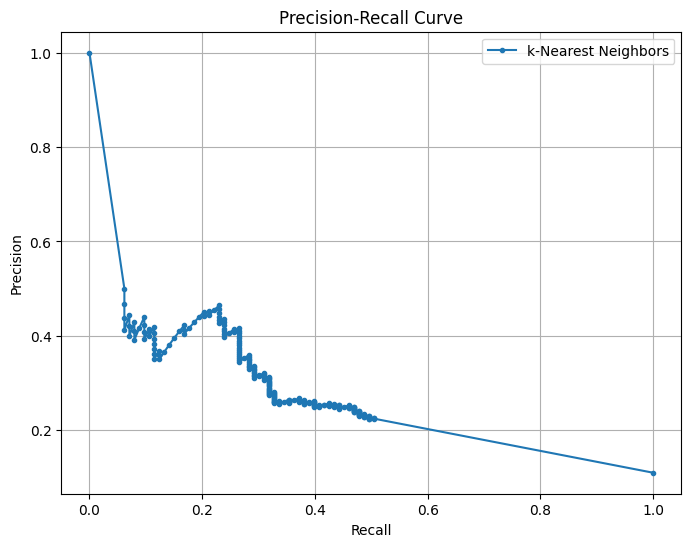

In [82]:
# precision-recall curve for k-nearest neighbors
display_precision_recall_curve(knn_precision, knn_recall, 'k-Nearest Neighbors')

In [83]:
thresholds = [0.4, 0.5, 0.6]
print_metrics(y_test, y_pred, y_pred_probs, thresholds = thresholds)

threshold = 0.4: recall=0.283, precision=0.333, f1=0.306
[[ 32  81]
 [ 64 853]]

threshold = 0.5: recall=0.257, precision=0.408, f1=0.315
[[ 29  84]
 [ 42 875]]

threshold = 0.6: recall=0.204, precision=0.442, f1=0.279
[[ 23  90]
 [ 29 888]]



#### Observations
The K-nearest neighbor model is also not performing well as there are more false positives and false negatives than there are true positives.

### Support Vector Classifier

In [84]:
# svc grid search with standard scaling
X, y = get_selected_features_and_y(df_original, selected_features)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,
                                                   stratify = y)

svc_pipeline = create_model_pipeline(
    category_columns = category_columns,
    model = SVC())

param_grid = {
    'model__C': [0.0001, 0.001, 0.01, 0.1],
    'model__coef0': [0.0, 0.1],
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__gamma': ['scale', 'auto'],
    'model__max_iter': [300],
    'model__class_weight': ['balanced'],
    'model__probability': [True],
    'model__random_state': [42],
}

extra_mini_param_grid = {
    'model__C': [0.001],
    'model__coef0': [0.0],
    'model__kernel': ['sigmoid'],
    'model__gamma': ['scale'],
    'model__max_iter': [5000],
    'model__class_weight': ['balanced'],
    'model__probability': [True],
    'model__random_state': [42],
}

svc_grid = perform_grid_search(svc_pipeline, param_grid=extra_mini_param_grid, scoring="f1")
svc_grid.fit(X_train, y_train)

best_estimator_svc = svc_grid.best_estimator_
y_pred = best_estimator_svc.predict(X_test)

print_model_info(best_estimator_svc)
print_scores("support vector classifier test (standard)", y_test.values, y_pred)

y_pred_probs = best_estimator_svc.predict_proba(X_test)[:, 1]
svc_precision, svc_recall, svc_thresholds = precision_recall_curve(y_test, y_pred_probs)

performing GridSearchCV
model.get_params():
{'memory': None, 'steps': [('js_encoder', JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing'])), ('scaler', StandardScaler()), ('model', SVC(C=0.001, class_weight='balanced', kernel='sigmoid', max_iter=5000,
    probability=True, random_state=42))], 'transform_input': None, 'verbose': False, 'js_encoder': JamesSteinEncoder(cols=['poutcome', 'month', 'job', 'contact', 'marital',
                        'housing']), 'scaler': StandardScaler(), 'model': SVC(C=0.001, class_weight='balanced', kernel='sigmoid', max_iter=5000,
    probability=True, random_state=42), 'js_encoder__cols': ['poutcome', 'month', 'job', 'contact', 'marital', 'housing'], 'js_encoder__drop_invariant': False, 'js_encoder__handle_missing': 'value', 'js_encoder__handle_unknown': 'value', 'js_encoder__model': 'independent', 'js_encoder__random_state': None, 'js_encoder__randomized': False, 'js_encoder__return_df': True, '

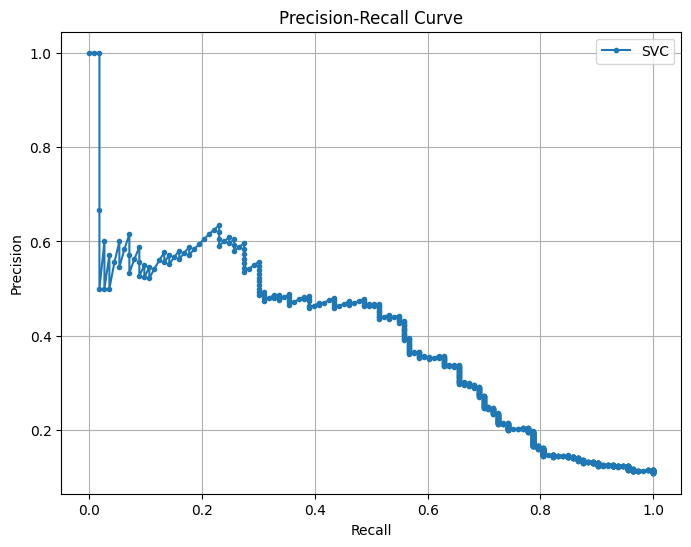

In [85]:
# precision-recall curve for k-nearest neighbors
display_precision_recall_curve(svc_precision, svc_recall, 'SVC')

In [86]:
thresholds = [0.4, 0.5, 0.6]
print_metrics(y_test, y_pred, y_pred_probs, thresholds = thresholds)

threshold = 0.4: recall=0.0, precision=0.0, f1=0.0
[[  0 113]
 [  0 917]]

threshold = 0.5: recall=0.0, precision=0.0, f1=0.0
[[  0 113]
 [  0 917]]

threshold = 0.6: recall=0.0, precision=0.0, f1=0.0
[[  0 113]
 [  0 917]]



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Observations
There is a descrepancy between the 0.5 probably threshold results reported by comparing actual and predicted y values using the method `confusion_matrix()` and the predicted results calculated using the SVC `predict_proba()` and reported using `recall_score()`, `precision_score()` and `f1_score()`. [SVC documentation](https://scikit-learn.org/stable/modules/svm.html#scores-probabilities) states that probability estimates may be inconsistent with the predictions:


> in binary classification, a sample may be labeled by predict as belonging to the positive class even if the output of predict_proba is less than 0.5; and similarly, it could be labeled as negative even if the output of predict_proba is more than 0.5.




I'm assuming that is the reason between the confusion matrix descrepancy in the 2nd and 3rd SVC cells.

Similar to the other models, the precision-recall curve drops off very quickly. The hyperparameter tuning of the Support Vector classifier scored using F1 scoring instead of recall because the resulting recall score would be 100% with poor precision.



## Conclusions
Recall was prioritized as the primary evaluation metric due to the class imbalance in the dataset and the business objective of avoiding missed sales opportunities. Under this assumption, false positives were considered tolerable if it meant capturing more true positives. The hyperparameter tuning of the Support Vector classifier, however was an exception and used F1 scoring instead. Otherwise, resulting SVC recall score would be 100% with poor precision.

None of the models demonstrated strong performance in predicting whether a customer would purchase a term deposit. There are two possible explanations for this outcome: (1) the dataset contains meaningful patterns that were not detected due to inadequate feature encoding or preprocessing, or (2) the features themselves may lack sufficient signal to distinguish between the target classes.

Among the models tested, the Support Vector Classifier (SVC) achieved the highest recall score at 0.81, but at the cost of a low precision score of 0.16. The next-best model in terms of recall was Logistic Regression, with a recall of 0.71 and a higher precision of 0.23.

The choice between the SVC and Logistic Regression depends on the acceptable cost of handling false positives. The SVC yields a 13.8% increase in true positives compared to Logistic Regression (91 vs. 80), but this comes with a 44.3% increase in false positives (476 vs. 265). If the operational cost of processing these additional false positives is acceptable, the SVC may be preferable. Otherwise, Logistic Regression offers a better balance between precision and recall, albeit with fewer captured positives.

Although the Decision Tree achieved the highest F1 score, its susceptibility to overfitting raises concerns about its ability to generalize to unseen data. As such, Logistic Regression and the SVC remain the more reliable options for deployment.

**Model Performance Summary**

| Model                      | Precision | Recall | F1       |
| ---------------------------|----------:|-------:|---------:|
| Baseline                   | 0.14      |   0.16 |   0.15   |
| Decision Tree              | 0.14      |   0.16 |   0.15   |
| Logistic Regression        | 0.14      |   0.16 |   0.15   |
| k-Nearest Neighbors        | 0.14      |   0.16 |   0.15   |
| Support Vector Classifier  | 0.14      |   0.16 |   0.15   |

</br>

**Logistic Regression Confusion Matrix**

|      | Predicted True | Predicted False |
|-----:|:---------------:|:--------------:|  
|True  | 80             | 33              |
|False | 265            | 652             |

</br>

**SVC Confusion Matrix**

|      | Predicted True | Predicted False |
|-----:|:---------------:|:--------------:|  
|True  | 91              | 22             |
|False | 476             | 441            |



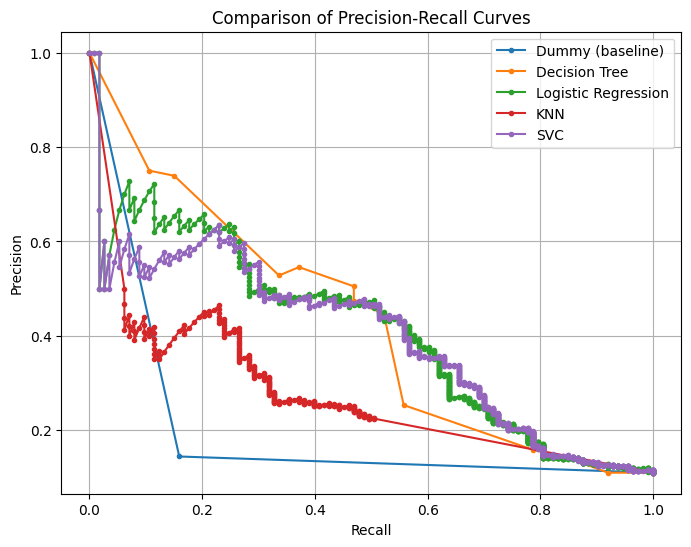

In [92]:
plt.figure(figsize=(8,6))

plt.plot(bl_recall, bl_precision, marker='.', label=f'Dummy (baseline)')
plt.plot(dt_recall, dt_precision, marker='.', label=f'Decision Tree')
plt.plot(lr_recall, lr_precision, marker='.', label=f'Logistic Regression')
plt.plot(knn_recall, knn_precision, marker='.', label=f'KNN')
plt.plot(svc_recall, svc_precision, marker='.', label=f'SVC')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Comparison of Precision-Recall Curves')
plt.legend()
plt.grid()
plt.show()